/usr/local/lib64/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/usr/local/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Masa real: 6
Masa estimada (subrogado): 6.0
Match: 0.7253
Tiempo subrogado: 0.0116 s
Tiempo exacto (generar onda): 0.4294 s


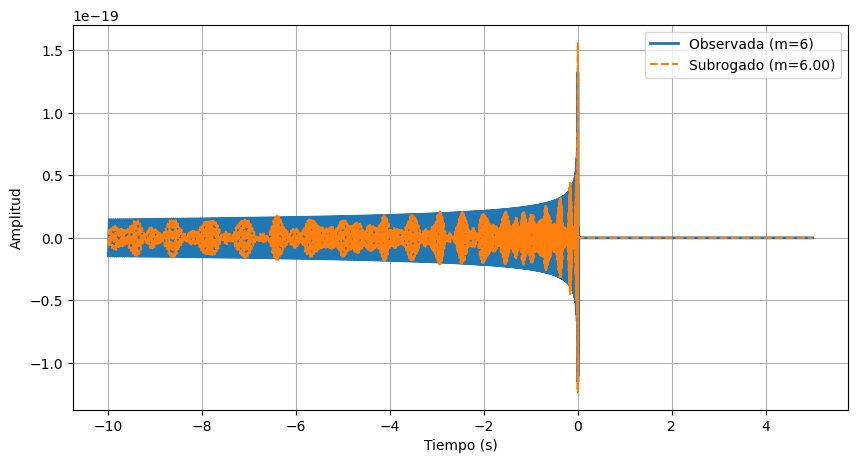

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from scipy.interpolate import Rbf
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 20.0
apx = "SEOBNRv4_ROM"

# ================================
# Función segura para centrar alrededor del merger
# ================================
def safe_time_slice(h, t_before=10, t_after=5):
    """Slice seguro de la onda alrededor del pico sin salirse de los extremos"""
    t_peak = h.sample_times[np.argmax(abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

# ================================
# Señal "observada" (onda real)
# ================================
m_real = 6
hp_obs, _ = get_td_waveform(approximant=apx,
                            mass1=m_real, mass2=m_real,
                            delta_t=delta_t, f_lower=f_low)
hp_obs = safe_time_slice(hp_obs, t_before=10, t_after=5)
times = hp_obs.sample_times.numpy()
N = len(hp_obs)  # longitud de referencia

# ================================
# Conjunto de entrenamiento
# ================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),   # cobertura amplia
    [5, 5.5, 6, 6.5, 7]       # densidad cerca de 6
]))

W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    
    # Convertir a numpy array de longitud N
    h_arr = np.zeros(N)
    h_np = h.numpy()
    L = min(len(h_np), N)
    h_arr[:L] = h_np[:L]
    W_list.append(h_arr)

# Matriz de forma (N, num_masses) para SVD
W = np.array(W_list).T  # transponer para que cada columna sea una onda

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = min(50, U.shape[1])
basis = U[:, :k]  # base reducida de tamaño (N, k)

# ================================
# Coeficientes proyectados
# ================================
coeffs = basis.T @ W  # forma (k, num_masses)

# ================================
# Interpoladores (RBF)
# ================================
rbf_list = []
for i in range(k):
    rbf = Rbf(mass_range, coeffs[i, :],
              function="multiquadric", smooth=0.01)
    rbf_list.append(rbf)

def surrogate(m):
    coeff_pred = np.array([rbf(m) for rbf in rbf_list])
    return basis @ coeff_pred  # reconstrucción de la onda

# ================================
# Evaluación del subrogado
# ================================
m_test = m_real
start = time.time()
h_sub = surrogate(m_test)
time_sub = time.time() - start

# Generación exacta para comparar tiempos
start = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_test, mass2=m_test,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)

# Asegurar misma longitud que hp_obs
h_arr = np.zeros(N)
h_np = h_exact.numpy()
L = min(len(h_np), N)
h_arr[:L] = h_np[:L]
h_exact = h_arr
time_exact = time.time() - start

# ================================
# Métrica: mejor masa estimada
# ================================
matches = []
for m in mass_range:
    h_try = surrogate(m)
    ts_obs = TimeSeries(hp_obs, delta_t=delta_t)
    ts_try = TimeSeries(h_try, delta_t=delta_t)

    # PSD realista
    flen = len(ts_obs) // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)

best_idx = np.argmax(matches)
m_est = mass_range[best_idx]
best_match = matches[best_idx]

# ================================
# Resultados
# ================================
print(f"Masa real: {m_real}")
print(f"Masa estimada (subrogado): {m_est}")
print(f"Match: {best_match:.4f}")
print(f"Tiempo subrogado: {time_sub:.4f} s")
print(f"Tiempo exacto (generar onda): {time_exact:.4f} s")

# ================================
# Gráfico
# ================================
plt.figure(figsize=(10,5))
plt.plot(times, hp_obs, label=f"Observada (m={m_real})", lw=2)
plt.plot(times, h_sub, "--", label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()

Masa real: 6
Masa estimada (subrogado): 6.0
Match: 0.4352


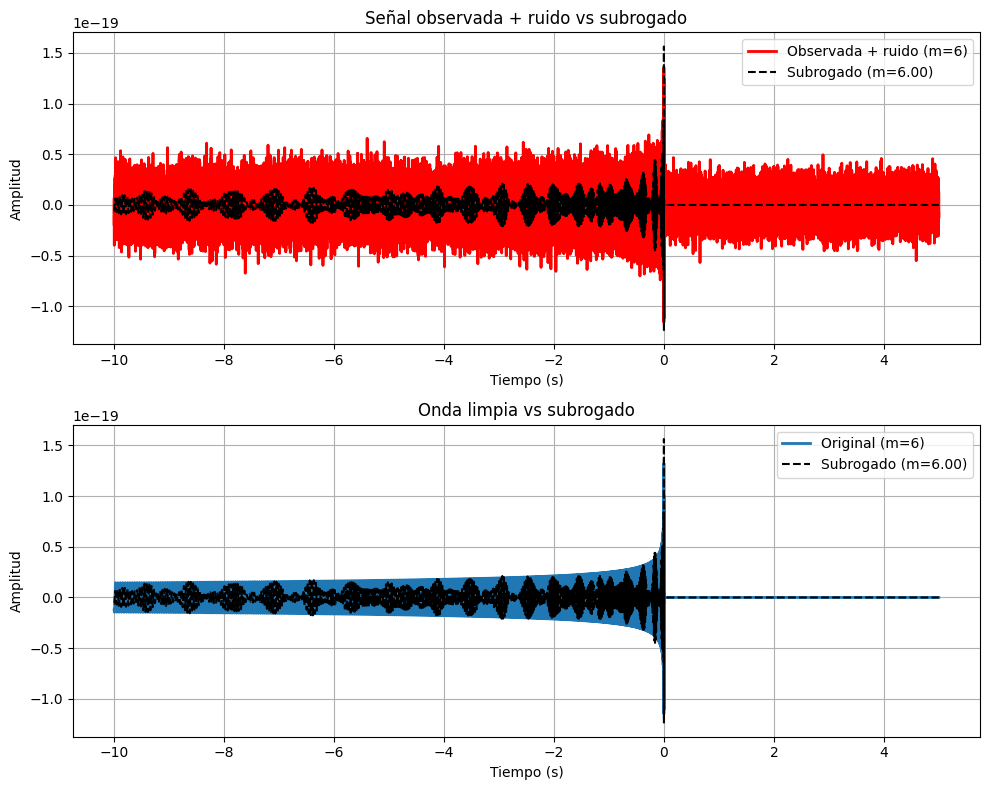

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from scipy.interpolate import Rbf
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 20.0
apx = "SEOBNRv4_ROM"

# ================================
# Función segura para centrar alrededor del merger
# ================================
def safe_time_slice(h, t_before=10, t_after=5):
    t_peak = h.sample_times[np.argmax(abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

# ================================
# Señal "observada" generada + ruido
# ================================
m_real = 6  # masa de tu onda
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)

# Convertir a NumPy para operaciones
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Agregar ruido gaussiano
sigma_noise = 0.1 * np.max(np.abs(hp_clean_np))  # escala del ruido
noise = np.random.normal(0, sigma_noise, size=N)

# Señal observada final (clean + ruido)
hp_obs = hp_clean_np + noise

# ================================
# Conjunto de entrenamiento
# ================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),   # cobertura amplia
    [5, 5.5, 6, 6.5, 7]       # densidad cerca de 6
]))

W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    
    h_arr = np.zeros(N)
    h_np = h.numpy()
    L = min(len(h_np), N)
    h_arr[:L] = h_np[:L]
    W_list.append(h_arr)

W = np.array(W_list).T  # forma (N, num_masses)

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = min(50, U.shape[1])
basis = U[:, :k]

# ================================
# Coeficientes proyectados
# ================================
coeffs = basis.T @ W

# ================================
# Interpoladores (RBF)
# ================================
rbf_list = []
for i in range(k):
    rbf = Rbf(mass_range, coeffs[i, :], function="multiquadric", smooth=0.01)
    rbf_list.append(rbf)

def surrogate(m):
    coeff_pred = np.array([rbf(m) for rbf in rbf_list])
    return basis @ coeff_pred

# ================================
# Estimación de la masa a partir de la señal observada
# ================================
matches = []
for m in mass_range:
    h_try = surrogate(m)
    ts_obs = TimeSeries(hp_obs, delta_t=delta_t)
    ts_try = TimeSeries(h_try, delta_t=delta_t)

    flen = len(ts_obs) // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)

best_idx = np.argmax(matches)
m_est = mass_range[best_idx]
best_match = matches[best_idx]

# ================================
# Resultados
# ================================
print(f"Masa real: {m_real}")
print(f"Masa estimada (subrogado): {m_est}")
print(f"Match: {best_match:.4f}")

# ================================
# Gráficos: señal observada + ruido y onda limpia
# ================================
plt.figure(figsize=(10,8))

# ------------------------
# Gráfico 1: señal observada + ruido vs subrogado
# ------------------------
plt.subplot(2,1,1)
plt.plot(times, hp_obs, color='red', label=f"Observada + ruido (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--", color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal observada + ruido vs subrogado")
plt.legend()
plt.grid()

# ------------------------
# Gráfico 2: onda limpia vs subrogado
# ------------------------
plt.subplot(2,1,2)
plt.plot(times, hp_clean_np, label=f"Original (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--", color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Onda limpia vs subrogado")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Masa real: 6
Masa estimada (subrogado): 6.0
Error en estimación: 0.0000
Mejor match: 0.4352
Tiempo subrogado: 2.9327 s
Tiempo exacto (generación de onda): 0.3047 s


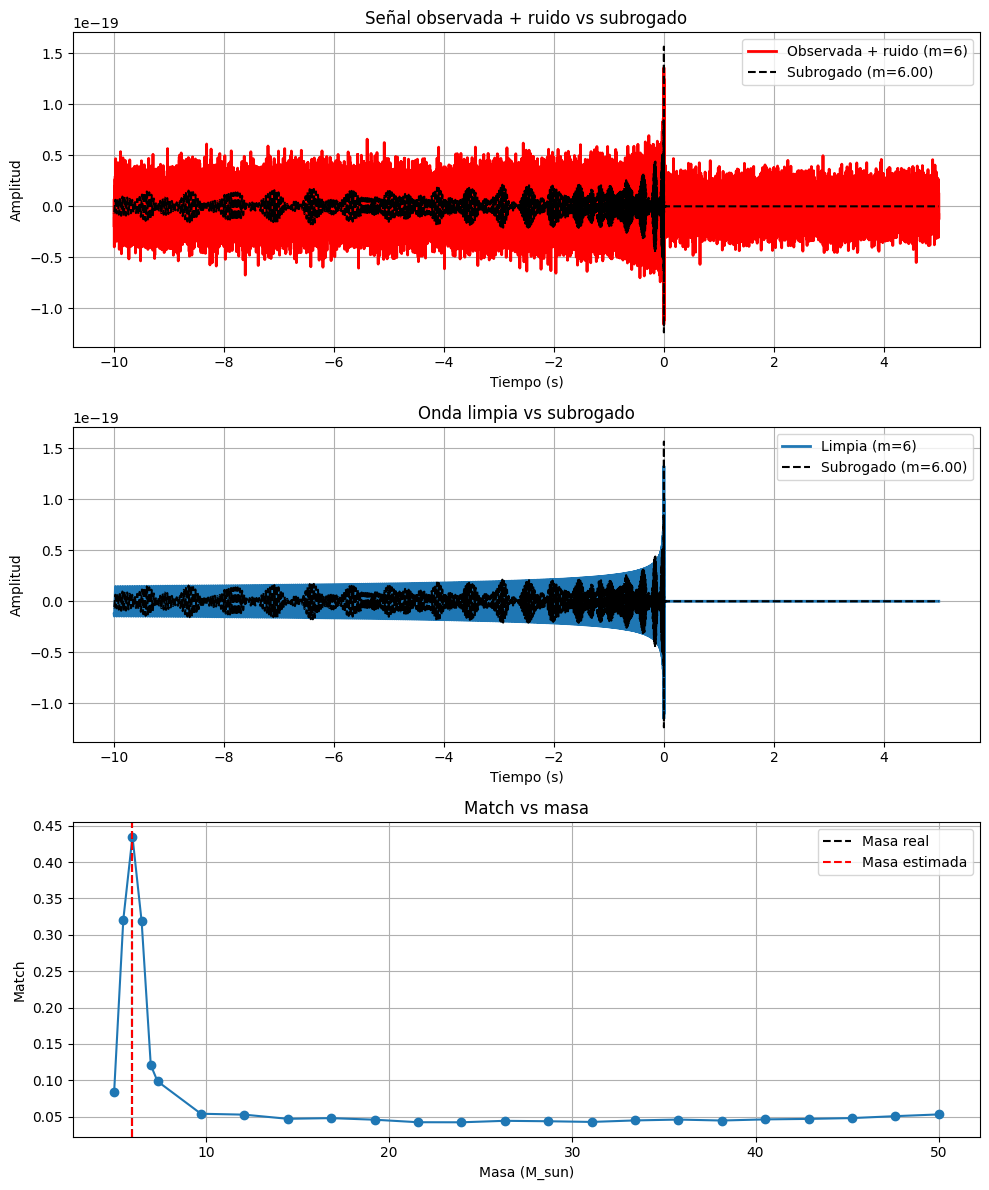

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from scipy.interpolate import Rbf
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 20.0
apx = "SEOBNRv4_ROM"

# ================================
# Función para centrar la onda
# ================================
def safe_time_slice(h, t_before=10, t_after=5):
    t_peak = h.sample_times[np.argmax(abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

# ================================
# Señal limpia y señal observada con ruido
# ================================
m_real = 6
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (con ruido)
sigma_noise = 0.1 * np.max(np.abs(hp_clean_np))
noise = np.random.normal(0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# ================================
# Conjunto de entrenamiento
# ================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))

W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_arr = np.zeros(N)
    L = min(len(h.numpy()), N)
    h_arr[:L] = h.numpy()[:L]
    W_list.append(h_arr)

W = np.array(W_list).T

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = min(50, U.shape[1])
basis = U[:, :k]
coeffs = basis.T @ W

# ================================
# Interpoladores (RBF)
# ================================
rbf_list = [Rbf(mass_range, coeffs[i, :], function="multiquadric", smooth=0.01) for i in range(k)]

def surrogate(m):
    coeff_pred = np.array([rbf(m) for rbf in rbf_list])
    return basis @ coeff_pred

# ================================
# Estimación de masa a partir de la señal observada
# ================================
matches = []
start_sub = time.time()
for m in mass_range:
    h_try = surrogate(m)
    ts_obs = TimeSeries(hp_obs, delta_t=delta_t)
    ts_try = TimeSeries(h_try, delta_t=delta_t)

    flen = len(ts_obs) // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = np.argmax(matches)
m_est = mass_range[best_idx]
best_match = matches[best_idx]
error_m = abs(m_est - m_real)

# ================================
# Tiempo de generación exacta
# ================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# ================================
# Resultados
# ================================
print(f"Masa real: {m_real}")
print(f"Masa estimada (subrogado): {m_est}")
print(f"Error en estimación: {error_m:.4f}")
print(f"Mejor match: {best_match:.4f}")
print(f"Tiempo subrogado: {time_sub:.4f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")

# ================================
# Gráficos
# ================================
plt.figure(figsize=(10,12))

# Gráfico 1: señal observada + ruido vs subrogado
plt.subplot(3,1,1)
plt.plot(times, hp_obs,color='red', label=f"Observada + ruido (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal observada + ruido vs subrogado")
plt.legend()
plt.grid()

# Gráfico 2: onda limpia vs subrogado
plt.subplot(3,1,2)
plt.plot(times, hp_clean_np, label=f"Limpia (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--", color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Onda limpia vs subrogado")
plt.legend()
plt.grid()

# Gráfico 3: match vs masa
plt.subplot(3,1,3)
plt.plot(mass_range, matches, "-o")
plt.axvline(m_real, color="k", linestyle="--", label="Masa real")
plt.axvline(m_est, color="r", linestyle="--", label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match")
plt.title("Match vs masa")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [9]:
# Match de onda limpia vs subrogado
ts_clean = TimeSeries(hp_clean_np, delta_t=delta_t)
ts_sub = TimeSeries(surrogate(m_real), delta_t=delta_t)
flen = len(ts_clean)//2 + 1
psd = aLIGOZeroDetHighPower(flen, ts_clean.delta_f, f_low)
match_clean, _ = match(ts_clean, ts_sub, psd=psd, low_frequency_cutoff=f_low)
print("Match onda limpia vs subrogado:", match_clean)


Match onda limpia vs subrogado: 0.7253345235015267
